In [40]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.exceptions import QiskitError

class AmplitudeEmbedding:
    
    def __init__(
        self,
        num_qubits: int
    
    ):
        
        """
    Class that generates a general feature map that can map any statevector given input in the form of angles.
    """
        
        r"""
        Args:

            num_qubits: Integer that describes the number of qubits that amplitude embedding is being applied on.
            Note: To map a statevector with 8 elements only requires 3 qubits due to the log base 2 of 8 = 3.
            
        Computing the angles can be done with help from [2]. DO NOT TRY TO CREATE A STATEVECTOR IF YOU DO NOT HAVE AN
        ADEQUATE NUMBER OF ANGLE PARAMETERS. This error is outside of the class.
            
        **References:**
        [1] https://docs.pennylane.ai/en/stable/introduction/templates.html

        [2] https://github.com/Qiskit/qiskit/blob/stable/0.20/qiskit/circuit/library/data_preparation/state_preparation.py
        """
    
        if num_qubits <= 0:
            raise QiskitError("num_qubits must be a positive integer.")
            
        self.num_qubits = num_qubits
        self.num_gates = sum(2**i for i in range(1, num_qubits + 1)) * 2  
        self.parameters = ParameterVector('x', length=self.num_gates)
        self.target_sequences = self.generate_target_sequences()

    def generate_target_sequences(self):
        def generate_sequence(n):
            if n == 2:
                return [1, 1]
            elif n == 3:
                return [1, 2, 1]
            else:
                previous_sequence = generate_sequence(n - 1)
                return previous_sequence + [n - 1] + previous_sequence

        all_sequences = []
        for n in range(self.num_qubits, 1, -1):
            all_sequences.append(generate_sequence(n))
        return all_sequences

    def create_quantum_circuit(self):
        array = [(2 ** i) // 2 for i in range(self.num_qubits, 0, -1)]
        qc = QuantumCircuit(self.num_qubits)
        param_index = 0  

        for qubit, num_gates in enumerate(array):
            if qubit < len(self.target_sequences):
                target_sequence = self.target_sequences[qubit]
            else:
                target_sequence = [1] * (num_gates - 1)

            for i in range(num_gates):
                qc.rz(-self.parameters[param_index], qubit)
                param_index += 1
                if i < num_gates - 1:
                    target_qubit = (qubit + target_sequence[i % len(target_sequence)]) % self.num_qubits
                    qc.cx(target_qubit, qubit)

            for i in range(num_gates):
                qc.ry(-self.parameters[param_index], qubit)
                param_index += 1
                if i < num_gates - 1:
                    target_qubit = (qubit + target_sequence[i % len(target_sequence)]) % self.num_qubits
                    qc.cx(target_qubit, qubit)

        return qc.inverse()

In [49]:
quantum_circuit = AmplitudeEmbedding(num_qubits=3).create_quantum_circuit()

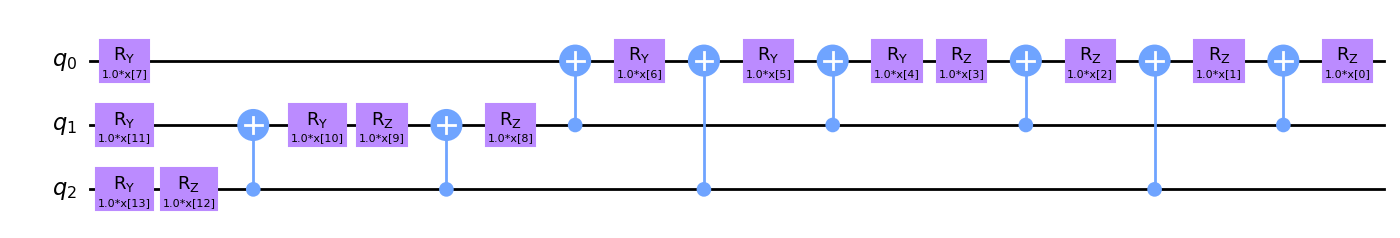

In [50]:
quantum_circuit.draw(output='mpl')